In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.15) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['NaiveModels.ipynb', '.ipynb_checkpoints', 'test.csv', 'train.csv', 'NaNHandleModels.ipynb', 'HousePrices.ipynb', 'OutlinersModels.ipynb', 'EDA.ipynb']


In [2]:
### 1. 'YearBuilt', "SaleCondition"
### 2. Random
### 3. All 

In [3]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [4]:
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test = pd.DataFrame.from_csv(test_path, index_col=0)
              
    return train, test

# Model with missing data handling

In [5]:
train, test = load_data()

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
def preprocessing(data):
    cols_drop = ["MiscFeature", "Fence", "PoolQC", "Alley", "FireplaceQu"]
    data.drop(columns=cols_drop, axis=1, inplace=True)
#     Categorical
    obj_df = data.select_dtypes(include=['object']).copy()
    cols = ["BsmtQual", "BsmtCond", "BsmtExposure","BsmtFinType1", "BsmtFinType2"]
    for i in cols:
        obj_df[i].fillna(obj_df[i].value_counts().idxmax(), inplace=True)
    obj_df['Electrical'].fillna(obj_df['Electrical'].value_counts().idxmax(), inplace=True)
    obj_df.loc[:, ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]] = obj_df.loc[:, ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]].fillna("None")
    obj_df["MasVnrType"].fillna("None", inplace=True)
#     Numerical
    num_df = data.select_dtypes(exclude=['object']).copy()
    num_df['GarageYrBlt'].fillna(0, inplace=True)
    num_df['MasVnrArea'].fillna(num_df['MasVnrArea'].value_counts().idxmax(), inplace=True)
    num_df['LotFrontage'].fillna(num_df['LotFrontage'].value_counts().idxmax(), inplace=True)
    
    num_norm = (num_df - num_df.mean()) / (num_df.max() - num_df.min())
    return pd.concat([obj_df, num_norm], axis=1)

In [13]:
train = preprocessing(train)
test = preprocessing(test)
train_y = train.SalePrice 
train_X = train.drop('SalePrice', axis=1)

KeyError: "['MiscFeature' 'Fence' 'PoolQC' 'Alley' 'FireplaceQu'] not found in axis"

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_y, test_size=0.2, shuffle=None)

In [ ]:
def regressor_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols):
    periods = 10
    steps_per_period = steps / periods
    # Create a linear classifier object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    regressor = tf.estimator.DNNRegressor(
        feature_columns=cols,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir='/tmp/model3'
    )
  
    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
    #     num_epochs=None,
        shuffle=True,
    #     target_column='target'
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )
  
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        training_predictions = regressor.predict(input_fn=ptraining_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = regressor.predict(input_fn=validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, y_train))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, y_test))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return regressor, training_rmse, validation_rmse

In [14]:
# yearb = tf.feature_column.numeric_column('YearBuilt')
cols = []
# cond = tf.feature_column.categorical_column_with_vocabulary_list('SaleCondition', ['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'])


cols = [tf.feature_column.numeric_column(i) for i in train.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).columns.values]
# cols = [yearb]
# cols = [cond]

Training model...
LogLoss (on training data):
  period 00 : 123302.42
  period 01 : 123493.90
  period 02 : 124547.78
  period 03 : 123404.08
  period 04 : 126897.89
  period 05 : 129091.72
  period 06 : 128675.44
  period 07 : 120687.87
  period 08 : 116052.07
  period 09 : 116947.44
Model training finished.
Final RMSE (on training data):   116947.44
Final RMSE (on validation data): 87725.91


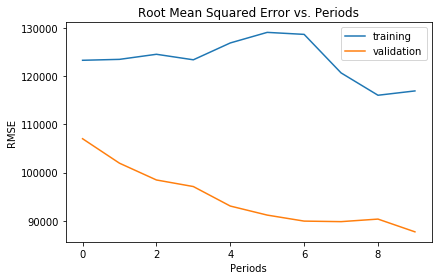

In [15]:
regressor = regressor_model(
    learning_rate=0.005,
    steps=500,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols)